In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import pymc as pm

In [2]:
sns.set_theme(style="ticks")

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Dummy data placeholders
time, states = 100, 2 
tr_predictors, em_predictors = 3, 1
em_output = 1

u_tr = xr.DataArray( rng.normal(size=(time, tr_predictors)), dims=("time", "tr_wts"))

u_em = xr.DataArray( rng.normal(size=(time)), dims=("time"))

y = xr.DataArray( rng.vonmises(2.5, 1, size=(time)), dims=("time"))

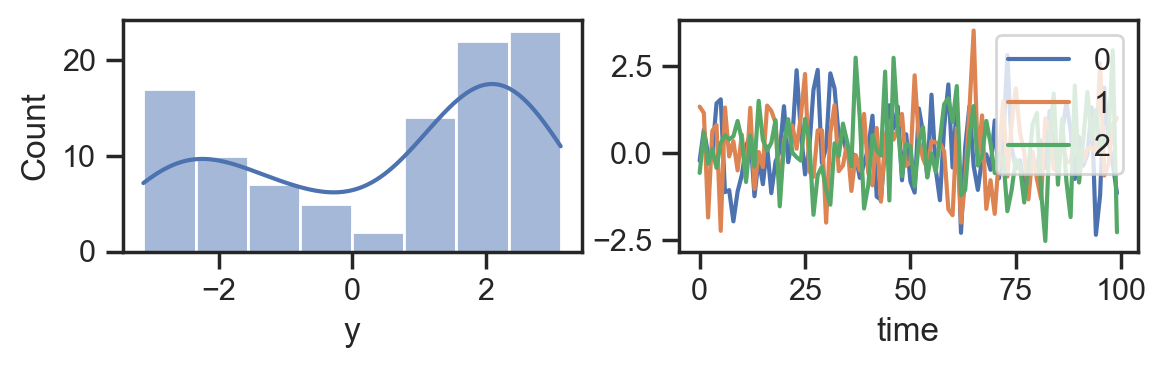

In [4]:
# Make 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi = 200)

sns.histplot(
    y, 
    ax=axs[0], 
    kde=True,
    stat="count",
).set_xlabel("y")

sns.lineplot(
    data=u_tr,
    ax=axs[1],
    dashes=False,
).set_xlabel("time")

plt.tight_layout()
plt.show()

$$

z_t \mid x_t^{tr}, \theta \sim Cat( a + b \cdot x_t^{tr} )

\\

y_t \mid z_t, x_t^{em}, \theta \sim VonMises( y_t \mid  C_{z_t} \cdot x_t^{em}, \kappa_{z_t})

$$

In [6]:
with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=5, shape=states)
    b = pm.Normal("b", mu=0, sigma=5, shape=(states, tr_predictors))
    
    # Linear predictors for class probabilities
    eta = a + pm.math.dot(u_tr.to_numpy(), b.T)
    class_probs = pm.math.softmax(eta)
    
    # Component parameters
    mu_sens = u_em.to_numpy() * 1
    mu_insens = u_em.to_numpy() * 0.1
    mu = np.stack([mu_sens, mu_insens], axis=-1)  # Shape (100, 2)
    kappa = np.array([6, 0.5])  # Shape (2,)
    
    # Mixture model using MixtureSameFamily
    y_obs = pm.Mixture(
        "y_obs",
        w=pm.Categorical.dist(p=class_probs),
        comp_dists=[pm.VonMises.dist(mu=mu, kappa=kappa)],
        observed=y.to_numpy()
    )
    
    # Sample from the posterior
    trace = pm.sample(1000)

/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/pymc/distributions/mixture.py:282: UserWarning: Single component will be treated as a mixture across the last size dimension.
To disable this warning do not wrap the single component inside a list or tuple
  warnings.warn(


ValueError: Alloc static input type and target shape are incompatible: Vector(int64, shape=(100,)) vs (100, 2)